# Numerical approximation of FBSDEs

Consider following FBSDE:

The forward part:
$$
\left\{\begin{array} {l} {{d X_{t}=\mu( t, X_{t} ) d t+\sigma( t, X_{t} ) d W_{t}, \quad t \in[ 0, T ]}} \\ {{X_{0}=x,}} \\ \end{array} \right.  
$$
and backward part:
$$
\left\{\begin{array} {l} {{{-d Y_{t}=f \left( t, X_{t}, Y_{t}, Z_{t} \right) d t-Z_{t} d W_{t}, \quad t \in[ 0, T ]}}} \\ {{{Y_{T}=\Phi( X_{T} ),}}} \\ \end{array} \right. 
$$

which have under certain conditions of the functions has an unique solution $(X,Y,Z)$.

## Euler sheme forward part

We time discretize uniformly with time step $\Delta_{i}^{N}$ 
 the forward SDE using an Euler scheme:

$$
\left\{\begin{array} {l} {{X_{0}^{N}=X_{0}}} \\ {{X_{t_{i}}^{N}=X_{t_{i-1}}^{N}+\mu \left( t_{i-1}, X_{t_{i-1}}^{N} \right) \Delta_{i}^{N}+\sigma\left(t_{i-1}, X_{t_{i-1}}^{N} \right) \Delta W_{i}^{N}.}} \\ \end{array} \right. 
$$


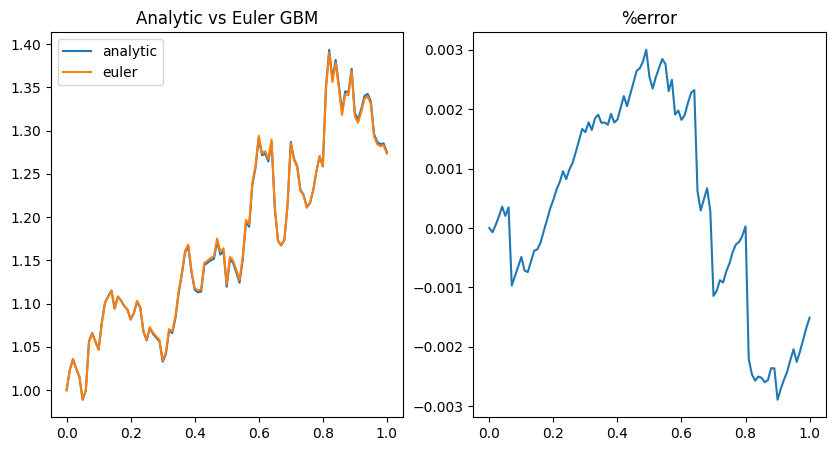

In [48]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_GBM_path(S0, mu, sigma, T, dt, num_paths):
    """Simulate multiple paths of the geometric Brownian motion process S_{t}=S_{0} exp((r-sigma^2/2)t + sigma*W_{t})"""
    N = round(T/dt)
    t = np.linspace(0, T, N+1)
    W = np.random.standard_normal(size = (num_paths, N)) 
    W = np.insert(W, 0, 0, axis=1)
    W = np.cumsum(W, axis=1)*np.sqrt(dt) ### standard brownian motion
    X = (mu - 0.5*sigma**2)*t + sigma*W 
    S = S0*np.exp(X) ### geometric brownian motion
    return S

def euler_maruyama(X0, mu, sigma, T, N, num_paths):
    dt = T/N
    t = np.linspace(0, T, N+1)
    X = np.zeros((num_paths, N+1))
    X[:, 0] = X0
    for j in range(num_paths):
        for i in range(1, N+1):
            X[j, i] = X[j, i-1] + mu(t[i-1], X[j, i-1]) * dt + sigma(t[i-1],X[j, i-1]) * np.random.normal(0,np.sqrt(dt))
    return t, X

def muGBM(mu): return lambda t, X: mu*X
def sigmaGBM(sigma): return lambda t,X: sigma*X

mu = 0.07
sigma = 0.2
X0 = 1
T = 1 
N = 100
seed = np.random.randint(0,100000)
np.random.seed(seed)
realization_euler_gbm = euler_maruyama(X0, muGBM(mu), sigmaGBM(sigma), T, N,1)

np.random.seed(seed)
paths = simulate_GBM_path(X0, mu, sigma, T, T/N, 1)

fig, axs = plt.subplots(1,2,figsize=(10,5))

# First subplot
axs[0].plot(np.linspace(0,T,N+1), paths[0, :], label="analytic")
axs[0].plot(realization_euler_gbm[0], realization_euler_gbm[1][0,:], label="euler")
axs[0].legend()
axs[0].set_title('Analytic vs Euler GBM')

# Second subplot
axs[1].plot(realization_euler_gbm[0], (realization_euler_gbm[1][0,:]-paths[0,:])/(paths[0,:]+np.finfo(float).eps), label="euler")
axs[1].set_title('%error')

plt.show()

## Euler scheme backward part
See course slides:

$$
\left\{\begin{array} {l} {{{Y_{t_{N}}^{N}=\Phi\left( X_{t_{N}}^{N} \right),}}} \\ {{{Z_{t_{i}}^{N}=\frac{1} {\Delta_{i}^{N}} \mathbb{E} \left[ \Delta W_{i}^{N} Y_{t_{i+1}}^{N} \mid\mathcal{F}_{t_{i}} \right],}}} \\ {{{Y_{t_{i}}^{N}=\mathbb{E} \left[ Y_{t_{i+1}}^{N}+\Delta_{i}^{N} f \left( t_{i}, X_{t_{i}}^{N}, Y_{t_{i+1}}^{N}, Z_{t_{i}}^{N} \right) \mid\mathcal{F}_{t_{i}} \right].}}} \\ \end{array} \right. 
$$


## Comparing to PDE equivalence
To start (or simplicity) we consider 1-dimensional case and
 simpler $f$ linear in $u$, the relation between FBSDE and PDE is then the linear Feynman-Kac formula:

$$
f(r,x,y,z)= l(t,x) + \gamma u .
$$ 

$$
u_{t} + \frac{1}{2} \sigma^{2} u_{xx} + \mu u_{x} + \gamma u + l(t,x) = 0.
$$ 
then 
$$
(X_{t},Y_{t} = u(t,X_{t}), Z_{t} = \sigma(t,X_{t}) u_{x}(t,X_{t}))
.
$$ 
is solution. We use as test example:
$$
\begin{align}
u(t,x) &= tx \\    
\mu(t,x) &= -x \\
\sigma(t,x)&= t \\ 
\gamma &= 1  \\
l(t,x) &= -x
\end{align}
$$ 



We plot some realizations of the forward process:

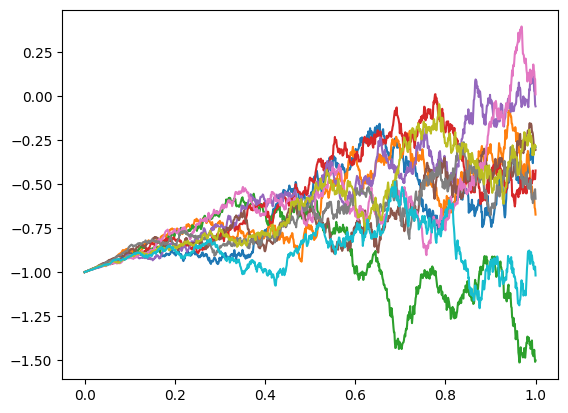

In [49]:
np.random.seed(1000)
realization_euler_gbm = euler_maruyama(-1, lambda t,x:-x, lambda t,x:t, 1, 1000,10)
for p in realization_euler_gbm[1]:
    plt.plot(realization_euler_gbm[0], p)
plt.show()

# Deep BSDE solver

In [73]:
import tensorflow as tf
import numpy as np


class DeepBSDE(tf.keras.Model):
    def __init__(self, 
                 t0=0.0,
                 t1=1.0,
                 dim=1,
                 X0=1.0,
                 time_steps=20,
                 mu = 0.07,
                 r=0.02,
                 sigma=0.2,
                 learning_rate=1e-2,
                 num_hidden_layers=2,
                 num_neurons=200,
                 DTYPE="float32",
                 **kwargs):
        """Set up basic architecture of deep BSDE NN model."""
        
        super().__init__(**kwargs)
        
        self.t0 = t0
        self.t1 = t1
        self.N = time_steps
        self.dim = dim
        self.r = r
        self.DTYPE = DTYPE
        self.mu = mu
        self.sigma = sigma
        self.x = X0*np.ones(self.dim)
        self.dt = (t1 - t0)/(self.N)
        self.sqrt_dt = np.sqrt(self.dt)
        self.learning_rate = learning_rate
        
        self.t_space = np.linspace(self.t0, self.t1, self.N + 1)[:-1]
        
        tf.keras.backend.set_floatx(self.DTYPE)
        # Set optimizer
        self.optimizer=tf.keras.optimizers.Adam(self.learning_rate,
                                                epsilon=1e-8)
        
        # Initialize value and gradient of u(t_0,X_{t_0}) by zeros
        #self.u0 = tf.Variable(np.zeros((1),dtype=DTYPE))
        #self.gradu0 = tf.Variable(np.zeros((1,self.dim),dtype=DTYPE))
        
        # Alternatively, initialize both randomly
        self.u0 = tf.Variable(np.random.uniform(10.0, 20.0,size=(1)).astype(self.DTYPE))
        self.gradu0 = tf.Variable(np.random.uniform(-1e-1, 1e-1, size=(1, self.dim)).astype(self.DTYPE))
        
        # Create template of dense layer without bias and activation
        _dense = lambda dim: tf.keras.layers.Dense(
            units=dim,
            activation=None,
            use_bias=False)
        
        # Create template of batch normalization layer
        _bn = lambda : tf.keras.layers.BatchNormalization(
            momentum=.99,
            epsilon=1e-6,
            beta_initializer=tf.random_normal_initializer(0.0, stddev=0.1),
            gamma_initializer=tf.random_uniform_initializer(0.1, 0.5))
        
        
        # Initialize a list of networks approximating the gradient of u(t, x) at t_i
        self.gradui = []
        
        # Loop over number of time steps
        for _ in range(self.N - 1):
            
            # Batch normalization on dim-dimensional input
            this_grad = tf.keras.Sequential()
            this_grad.add(tf.keras.layers.Input(shape = (self.dim,)))
            this_grad.add(_bn())
            
            # Hidden layers of type (Dense -> Batch Normalization -> ReLU)
            for _ in range(num_hidden_layers):
                this_grad.add(_dense(num_neurons))
                this_grad.add(_bn())
                this_grad.add(tf.keras.layers.ReLU())
                
            # Dense layer followed by batch normalization for output
            this_grad.add(_dense(self.dim))
            this_grad.add(_bn())
            self.gradui.append(this_grad)
      
            
    def draw_X_and_dW(self, num_sample):
        """ Method to draw num_sample paths of X. """
        
        # Draw increments of Brownian motion
        dW = np.random.normal(loc=0.0, scale=self.sqrt_dt, size=(num_sample, self.dim, self.N)).astype(self.DTYPE)
        
        # Initialize and set array of paths
        X = np.zeros((num_sample, self.dim, self.N+1), dtype=self.DTYPE)
        
        X[:, :, 0] = np.ones((num_sample, self.dim)) * self.x
        
        for i in range(self.N):
            # This corresponds to the Euler-Maruyama Scheme of GBM
            X[:, :, i+1] = X[:, :, i]* (1+ self.mu* self.dt + self.sigma * dW[:, :, i])
            
        # Return simulated paths as well as increments of Brownian motion
        return X, dW
    
    @tf.function
    def call(self, inp, training=False):
        """
        Method to perform one forward sweep through the network
        given inputs: inp - (X, dW)
                      training - boolean variable indicating training
        """
        X, dW = inp # uses same dW as X
        num_sample = X.shape[0]
        
        
        e_num_sample = tf.ones(shape=[num_sample, 1], dtype=self.DTYPE)
        
        # Value approximation at t0
        y = e_num_sample * self.u0
        
        # Gradient approximation at t0
        z = e_num_sample * self.gradu0
        
        for i in range(self.N-1):
            
            t = self.t_space[i]
            
            # Optimal control is attained by gradient
            eta1 = self.fun_f(t, X[:, :, i], y, z) * self.dt
            eta2 = -tf.reduce_sum(z * dW[:, :, i], axis=1, keepdims=True)
            # here we are using the same dW

            y = y + eta1 + eta2

            # New gradient approximation
            # The division by self.dim acts as a stabilizer
            z = self.gradui[i](X[:, :, i + 1], training=training) / self.dim

        # Final step
        eta1 = - self.fun_f(self.t_space[self.N-1], X[:, :, self.N-1], y, z) * self.dt
        eta2 = tf.reduce_sum(z * dW[:, :, self.N-1], axis=1, keepdims=True)

        y = y + eta1 + eta2

        return y
    
    def loss_fn(self, inputs, training=False):
        X, _ = inputs
        # Forward pass to compute value estimates
        y_pred = self.call(inputs, training)
        
        # Exact values at final time
        y = self.fun_g(X[:, :, -1])
        loss = tf.reduce_mean(tf.square(y-y_pred)) #MSE
        
        return loss 
    
    @tf.function
    def train(self, inp):
        loss, grad = self.grad(inp, training=True)
        self.optimizer.apply_gradients(zip(grad, self.trainable_variables))
        return loss
    
    @tf.function
    def grad(self, inputs, training=False):
        with tf.GradientTape() as tape:
            loss = self.loss_fn(inputs, training=training)
        grad = tape.gradient(loss, self.trainable_variables)
        return loss, grad
    
    def fun_f(self, t, x, y, z):
        raise NotImplementedError
        
    def fun_g(self, t, x, y, z):
        raise NotImplementedError

In [74]:
class AmericanPut(DeepBSDE):
    def __init__(self,K=1.0, **kwargs):
        super().__init__(**kwargs)
        self.K = K
    # driver function

    @tf.function
    def q(self, x, y):
        return self.r * self.K * tf.cast(y <= self.fun_g(x), dtype=self.DTYPE)

    @tf.function
    def fun_f(self, t, x, y, z):
        return -self.r*y + self.q(x,y) 

    # Terminal/Final cost or payoff
    @tf.function
    def fun_g(self, x):
        return tf.maximum(self.K - x, 0)
    

In [75]:
test = AmericanPut(K=110, 
                   X0=100, 
                   time_steps=5, 
                   dim=1, 
                   r= 0.02,
                   mu=0.07, 
                   t0 =0,
                   t1 = 1,
                   sigma=0.3, 
                   learning_rate=1e-2, 
                   num_hidden_layers=2, 
                   num_neurons=100)

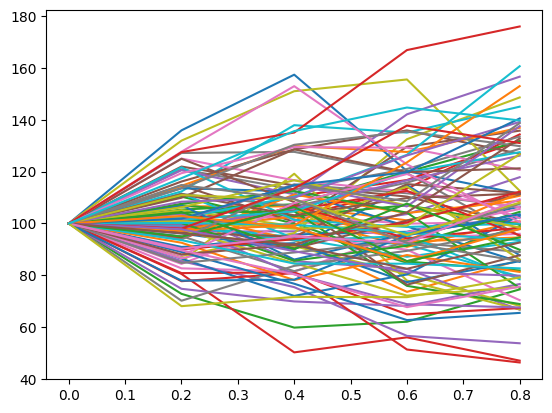

In [60]:
import matplotlib.pyplot as plt
np.random.seed(1000)
X, dW = test.draw_X_and_dW(100)
for p in X:
    plt.plot(test.t_space, p[0,:-1])
plt.show()

In [55]:

yy = test.call((X,dW))
print(yy)

tf.Tensor(
[[13.93459  ]
 [13.076759 ]
 [13.320243 ]
 [12.861567 ]
 [13.0380535]
 [13.010802 ]
 [13.242588 ]
 [12.68001  ]
 [13.541204 ]
 [14.15317  ]
 [12.797094 ]
 [13.106304 ]
 [13.756574 ]
 [12.977528 ]
 [14.351322 ]
 [13.15417  ]
 [13.323365 ]
 [13.2068815]
 [13.492627 ]
 [13.738616 ]
 [13.85232  ]
 [13.037165 ]
 [13.183012 ]
 [15.368458 ]
 [14.294872 ]
 [13.367066 ]
 [13.824475 ]
 [13.219284 ]
 [14.816794 ]
 [13.270439 ]
 [12.742491 ]
 [13.375605 ]
 [13.334887 ]
 [14.996063 ]
 [14.22656  ]
 [13.463658 ]
 [13.071329 ]
 [14.009952 ]
 [13.439745 ]
 [13.717176 ]
 [13.963674 ]
 [13.327378 ]
 [13.507416 ]
 [14.4023   ]
 [13.734687 ]
 [14.061652 ]
 [14.586875 ]
 [13.132679 ]
 [13.183465 ]
 [13.048548 ]
 [14.06034  ]
 [13.427331 ]
 [13.18552  ]
 [12.833573 ]
 [14.530721 ]
 [12.994368 ]
 [13.304816 ]
 [13.246377 ]
 [14.106943 ]
 [12.825757 ]
 [13.718129 ]
 [12.953037 ]
 [13.111462 ]
 [14.002783 ]
 [13.113747 ]
 [13.165505 ]
 [13.041289 ]
 [13.956468 ]
 [13.348707 ]
 [13.33571  ]
 [14.3377

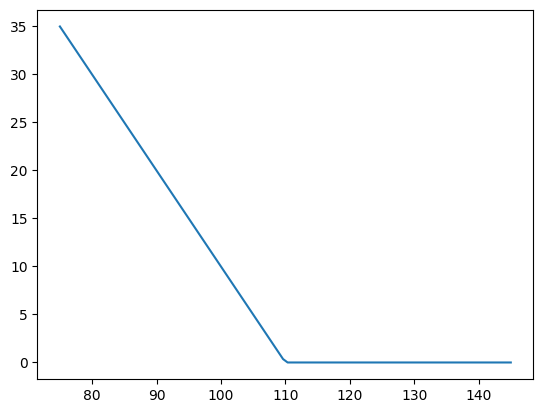

In [70]:
xx = np.linspace(75, 145, 100)
yy = [test.fun_g(x) for x in xx]

plt.plot(xx, yy)
plt.show()

In [71]:
from time import time

def experiment(model, sol,num_epochs=100,batch_size=100):
    # Initialize header
    print('  Iter        Loss        y   L1_rel    L1_abs   |   Time  Stepsize')
     
    # Init timer and history list
    t0 = time()
    history=[]
    for i in range(num_epochs):
        
        inp = model.draw_X_and_dW(batch_size)
        loss = model.train(inp)

        # Get current Y_0 \approx u(0,x)
        y = model.u0.numpy()[0]

        currtime = time() - t0
        l1abs = np.abs(y - sol)
        l1rel = l1abs / sol

        hentry = (i, loss.numpy(), y, l1rel, l1abs, currtime, model.learning_rate)
        history.append(hentry)
        if i%10 == 0:
            print('{:5d} {:12.4f} {:8.4f} {:8.4f}  {:8.4f}   | {:6.1f}  {:6.2e}'.format(*hentry))
    return history

In [76]:
experiment(test, sol = 15.20, num_epochs=100, batch_size=100)
print("test")

  Iter        Loss        y   L1_rel    L1_abs   |   Time  Stepsize


TypeError: unsupported format string passed to numpy.ndarray.__format__